#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [56]:
# CSV 파일 불러오기
train_data_path = '/content/drive/MyDrive/project3/data01_train.csv'
test_data_path = '/content/drive/MyDrive/project3/data01_test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# 'subject' 칼럼 삭제
train_data = train_data.drop(columns=['subject'])
test_data = test_data.drop(columns=['subject'])

# 수정된 데이터 저장
train_data.to_csv('data01_train_clean.csv', index=False)
test_data.to_csv('data01_test_clean.csv', index=False)

print("subject 칼럼이 삭제된 파일이 저장되었습니다.")

subject 칼럼이 삭제된 파일이 저장되었습니다.


#### 2) 기본 정보 조회

In [6]:
train_data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [7]:
train_data.isna().sum()

,0
tBodyAcc-mean()-X,0
tBodyAcc-mean()-Y,0
tBodyAcc-mean()-Z,0
tBodyAcc-std()-X,0
tBodyAcc-std()-Y,0
...,...
"angle(tBodyGyroJerkMean,gravityMean)",0
"angle(X,gravityMean)",0
"angle(Y,gravityMean)",0
"angle(Z,gravityMean)",0


In [1]:
# @title 기본 제목 텍스트
top_200 = ['tGravityAcc-mean()-X',
 'angle(X,gravityMean)',
 'tGravityAcc-energy()-X',
 'tGravityAcc-mean()-Y',
 'tGravityAcc-max()-X',
 'tGravityAcc-min()-Y',
 'tGravityAcc-min()-X',
 'angle(Y,gravityMean)',
 'tGravityAcc-max()-Y',
 'fBodyAccJerk-max()-X',
 'fBodyAccJerk-bandsEnergy()-1,16',
 'fBodyAccMag-std()',
 'tGravityAcc-arCoeff()-Y,2',
 'tGravityAcc-energy()-Y',
 'angle(Z,gravityMean)',
 'tGravityAccMag-std()',
 'tBodyGyroJerk-iqr()-Z',
 'fBodyAccJerk-bandsEnergy()-1,16.1',
 'fBodyAcc-entropy()-X',
 'tGravityAcc-mean()-Z',
 'fBodyAccMag-mad()',
 'fBodyAcc-mad()-X',
 'fBodyAcc-bandsEnergy()-1,16',
 'tGravityAccMag-mad()',
 'tGravityAcc-min()-Z',
 'tBodyAccJerk-std()-X',
 'fBodyAccJerk-energy()-X',
 'fBodyAccJerk-bandsEnergy()-1,24',
 'fBodyAccJerk-std()-X',
 'fBodyAcc-bandsEnergy()-1,24',
 'tBodyAccMag-std()',
 'tGravityAcc-arCoeff()-Z,1',
 'tBodyAcc-correlation()-X,Y',
 'tGravityAcc-arCoeff()-Z,3',
 'fBodyGyro-maxInds-Z',
 'fBodyAcc-mean()-X',
 'fBodyAccJerk-mean()-X',
 'tBodyAccJerk-entropy()-X',
 'tGravityAcc-arCoeff()-X,1',
 'tGravityAcc-arCoeff()-Y,1',
 'tGravityAcc-energy()-Z',
 'fBodyAcc-bandsEnergy()-1,8',
 'tBodyAccJerk-sma()',
 'tBodyAccJerkMag-energy()',
 'tBodyGyroJerk-mad()-Z',
 'tBodyAccJerk-iqr()-X',
 'tGravityAcc-entropy()-Y',
 'fBodyAccMag-energy()',
 'fBodyAcc-energy()-X',
 'tGravityAcc-max()-Z',
 'tBodyAccMag-mad()',
 'fBodyAccMag-mean()',
 'fBodyAcc-bandsEnergy()-9,16',
 'tGravityAcc-arCoeff()-Y,3',
 'fBodyAccMag-entropy()',
 'tBodyAcc-max()-X',
 'fBodyAccJerk-bandsEnergy()-9,16',
 'tBodyAccMag-arCoeff()1',
 'tGravityAcc-arCoeff()-Z,2',
 'tBodyGyroJerk-sma()',
 'fBodyAccJerk-mad()-X',
 'fBodyAccJerk-maxInds-Z',
 'tBodyGyroJerk-iqr()-X',
 'fBodyAcc-std()-X',
 'fBodyAccMag-sma()',
 'tGravityAccMag-arCoeff()1',
 'fBodyAcc-max()-X',
 'tGravityAcc-arCoeff()-Z,4',
 'tGravityAcc-sma()',
 'tGravityAcc-arCoeff()-X,2',
 'tBodyAccJerkMag-iqr()',
 'fBodyGyro-mean()-X',
 'fBodyAccJerk-bandsEnergy()-1,8',
 'fBodyGyro-bandsEnergy()-1,8',
 'tBodyAcc-mad()-X',
 'tBodyAccJerkMag-mad()',
 'fBodyGyro-meanFreq()-X',
 'tBodyGyro-max()-X',
 'tBodyGyro-iqr()-X',
 'tBodyAccMag-arCoeff()2',
 'tGravityAcc-arCoeff()-X,3',
 'tBodyGyro-entropy()-X',
 'tGravityAcc-arCoeff()-X,4',
 'fBodyGyro-bandsEnergy()-1,16',
 'fBodyAccJerk-bandsEnergy()-17,24.2',
 'fBodyAcc-meanFreq()-Z',
 'fBodyGyro-max()-X',
 'fBodyGyro-mad()-X',
 'tGravityAccMag-arCoeff()2',
 'tBodyAcc-std()-X',
 'tBodyGyroJerk-std()-X',
 'tBodyAccJerk-energy()-X',
 'tBodyAccJerkMag-sma()',
 'tGravityAcc-arCoeff()-Y,4',
 'tBodyGyro-energy()-X',
 'fBodyAccJerk-entropy()-X',
 'tBodyAcc-energy()-X',
 'tBodyAccJerk-iqr()-Y',
 'tBodyGyro-iqr()-Y',
 'tBodyAccMag-max()',
 'tBodyGyro-mad()-X',
 'tBodyAccJerkMag-mean()',
 'tBodyGyroJerkMag-mean()',
 'tBodyAccJerk-mad()-Z',
 'fBodyAccJerk-sma()',
 'tBodyGyroJerk-iqr()-Y',
 'tBodyAcc-correlation()-Y,Z',
 'fBodyGyro-sma()',
 'fBodyBodyAccJerkMag-mean()',
 'tBodyGyroMag-mean()',
 'fBodyAccJerk-mean()-Y',
 'fBodyGyro-std()-X',
 'tBodyAccJerk-energy()-Y',
 'fBodyGyro-maxInds-X',
 'fBodyAcc-sma()',
 'fBodyBodyAccJerkMag-entropy()',
 'tBodyGyro-std()-X',
 'tBodyGyroJerk-energy()-X',
 'tBodyAccMag-mean()',
 'fBodyAccMag-meanFreq()',
 'tGravityAcc-correlation()-X,Y',
 'tBodyGyro-min()-X',
 'fBodyAccMag-max()',
 'fBodyAcc-bandsEnergy()-17,32.2',
 'tGravityAcc-entropy()-X',
 'tBodyAccMag-sma()',
 'fBodyGyro-bandsEnergy()-1,24',
 'tBodyAcc-entropy()-X',
 'fBodyAcc-skewness()-X',
 'fBodyAcc-bandsEnergy()-1,8.1',
 'tBodyGyro-correlation()-Y,Z',
 'tGravityAcc-correlation()-Y,Z',
 'fBodyBodyGyroMag-meanFreq()',
 'tBodyGyroJerk-mad()-X',
 'fBodyGyro-bandsEnergy()-9,16',
 'tGravityAcc-std()-X',
 'tBodyAcc-iqr()-X',
 'tGravityAcc-mad()-X',
 'tBodyGyroJerk-arCoeff()-X,1',
 'fBodyGyro-entropy()-X',
 'fBodyGyro-energy()-X',
 'fBodyAccJerk-maxInds-X',
 'tBodyAcc-correlation()-X,Z',
 'tBodyAccJerk-std()-Y',
 'tGravityAccMag-iqr()',
 'tBodyGyroJerk-correlation()-X,Y',
 'fBodyAcc-kurtosis()-X',
 'fBodyAccMag-iqr()',
 'tGravityAcc-correlation()-X,Z',
 'tGravityAcc-mad()-Y',
 'fBodyBodyAccJerkMag-max()',
 'fBodyAccJerk-bandsEnergy()-1,24.1',
 'fBodyAccJerk-bandsEnergy()-17,24.1',
 'tGravityAccMag-mean()',
 'tGravityAcc-iqr()-X',
 'tGravityAcc-std()-Z',
 'fBodyAccJerk-bandsEnergy()-17,32.2',
 'fBodyAcc-max()-Y',
 'tBodyGyro-correlation()-X,Y',
 'fBodyAcc-bandsEnergy()-1,8.2',
 'fBodyBodyAccJerkMag-std()',
 'tBodyGyro-arCoeff()-X,1',
 'tBodyGyroJerk-entropy()-X',
 'fBodyAccJerk-std()-Y',
 'fBodyAcc-skewness()-Y',
 'tBodyGyroJerk-arCoeff()-X,3',
 'fBodyGyro-std()-Z',
 'fBodyGyro-max()-Z',
 'tBodyGyroJerk-min()-X',
 'tBodyGyro-mean()-X',
 'tBodyAccJerk-max()-Z',
 'fBodyBodyGyroJerkMag-std()',
 'tGravityAccMag-max()',
 'fBodyAccJerk-energy()-Y',
 'tBodyGyro-mean()-Z',
 'fBodyAccJerk-iqr()-X',
 'tGravityAcc-iqr()-Y',
 'fBodyGyro-kurtosis()-Z',
 'fBodyGyro-bandsEnergy()-41,48',
 'tGravityAcc-std()-Y',
 'fBodyAccJerk-bandsEnergy()-1,24.2',
 'tBodyAccMag-iqr()',
 'tBodyGyroJerk-std()-Y',
 'fBodyAcc-bandsEnergy()-1,16.1',
 'tBodyAcc-iqr()-Y',
 'tBodyAccJerk-max()-Y',
 'fBodyGyro-mad()-Z',
 'fBodyGyro-bandsEnergy()-1,16.1',
 'fBodyBodyGyroMag-skewness()',
 'fBodyGyro-skewness()-X',
 'tBodyGyro-iqr()-Z',
 'tBodyAccJerk-correlation()-X,Y',
 'tBodyGyro-correlation()-X,Z',
 'tBodyGyro-std()-Y',
 'fBodyGyro-bandsEnergy()-1,8.1',
 'tBodyGyro-mad()-Z',
 'fBodyAcc-kurtosis()-Y',
 'tBodyGyro-energy()-Z',
 'fBodyGyro-bandsEnergy()-1,8.2',
 'fBodyGyro-maxInds-Y']

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [57]:
data = train_data[top_200 + ['Activity']]
x =  data.drop(columns=['Activity'])
y = data['Activity']

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
x.head()

,tGravityAcc-mean()-X,"angle(X,gravityMean)",tGravityAcc-energy()-X,tGravityAcc-mean()-Y,tGravityAcc-max()-X,tGravityAcc-min()-Y,tGravityAcc-min()-X,"angle(Y,gravityMean)",tGravityAcc-max()-Y,fBodyAccJerk-max()-X,...,tBodyGyro-iqr()-Z,"tBodyAccJerk-correlation()-X,Y","tBodyGyro-correlation()-X,Z",tBodyGyro-std()-Y,"fBodyGyro-bandsEnergy()-1,8.1",tBodyGyro-mad()-Z,fBodyAcc-kurtosis()-Y,tBodyGyro-energy()-Z,"fBodyGyro-bandsEnergy()-1,8.2",fBodyGyro-maxInds-Y
0,0.875254,-0.601120,0.673768,-0.358842,0.805627,-0.334921,0.891969,0.331298,-0.370494,-0.991791,...,-0.981385,-0.199092,-0.115245,-0.968673,-0.999115,-0.973401,-0.404287,-0.999479,-0.999531,-0.612903
1,-0.134711,0.345205,-0.893830,0.924656,-0.200892,0.937432,-0.095343,-0.769186,0.873312,-0.994706,...,-0.993556,-0.383840,0.242365,-0.976701,-0.999625,-0.990307,-0.924312,-0.999887,-0.999937,-1.000000
2,0.965965,-0.833564,0.906252,-0.174095,0.891615,-0.145801,0.985606,0.202434,-0.195671,-0.996958,...,-0.990757,0.123411,-0.042415,-0.996322,-0.999991,-0.988340,-0.967663,-0.999876,-0.999898,-0.935484
3,0.927343,-0.695819,0.805419,-0.297703,0.858160,-0.275699,0.943954,0.287154,-0.309430,-0.378207,...,-0.385200,0.378782,-0.152709,-0.432211,-0.801150,-0.358557,-0.575339,-0.808021,-0.832382,-0.935484
4,0.901125,-0.705029,0.738738,-0.260540,0.858531,-0.263482,0.901943,0.264952,-0.236084,-0.355447,...,-0.539245,-0.376394,0.149007,-0.574059,-0.877827,-0.465635,-0.801513,-0.819772,-0.901147,-0.935484


### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [58]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [59]:
# LabelEncoder 객체 생성
encoder = LabelEncoder()

# 라벨 데이터 학습과 변환 수행
encoded_labels = encoder.fit_transform(data['Activity'])
train_data['Activity'] = encoded_labels
print(f"Encoded Labels: {encoded_labels}")
print(f"Classes: {encoder.classes_}")

Encoded Labels: [2 0 2 ... 0 5 1]
Classes: ['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


In [19]:
encoded_labels[:10]

array([2, 0, 2, 3, 4, 5, 3, 2, 2, 2])

In [55]:
# 클래스와 정수 매핑 확인
class_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print("Class to Integer Mapping:", class_mapping)

Class to Integer Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}


In [15]:
train_data['Activity']

,Activity
0,2
1,0
2,2
3,3
4,4
...,...
5876,1
5877,5
5878,0
5879,5


### (4) xxx 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [16]:
data = train_data[top_200+['Activity']]
x =  data.drop(columns=['Activity'])
y = data['Activity']

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

In [21]:
print(x_train_scaled.dtype, x_train_scaled.shape)
print(y_train.dtype, y_train.shape)

float64 (4704, 200)
int64 (4704,)


### (1) 모델1

In [22]:
nfeatures = x_train.shape[1]
nfeatures

200

In [23]:
clear_session()
base_model = Sequential([Input(shape = (nfeatures,)),Dense(6,activation = 'softmax')])
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6)                   │           1,206 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,206 (4.71 KB)

 Trainable params: 1,206 (4.71 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
base_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
base_model.fit(x_train_scaled,y_train,epochs=100,validation_split = 0.2)

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3518 - loss: 1.5050 - val_accuracy: 0.8087 - val_loss: 0.9919
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8175 - loss: 0.9158 - val_accuracy: 0.8512 - val_loss: 0.7498
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8773 - loss: 0.7018 - val_accuracy: 0.8629 - val_loss: 0.6164
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8828 - loss: 0.5763 - val_accuracy: 0.8544 - val_loss: 0.5364
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8871 - loss: 0.5000 - val_accuracy: 0.8778 - val_loss: 0.4753
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8972 - loss: 0.4445 - val_accuracy: 0.8874 - val_loss: 0.4306
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9056 - loss: 0.3977 - val_accuracy: 0.8948 - val_loss: 0.4004
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9071 - loss: 0.3733 - val_accu

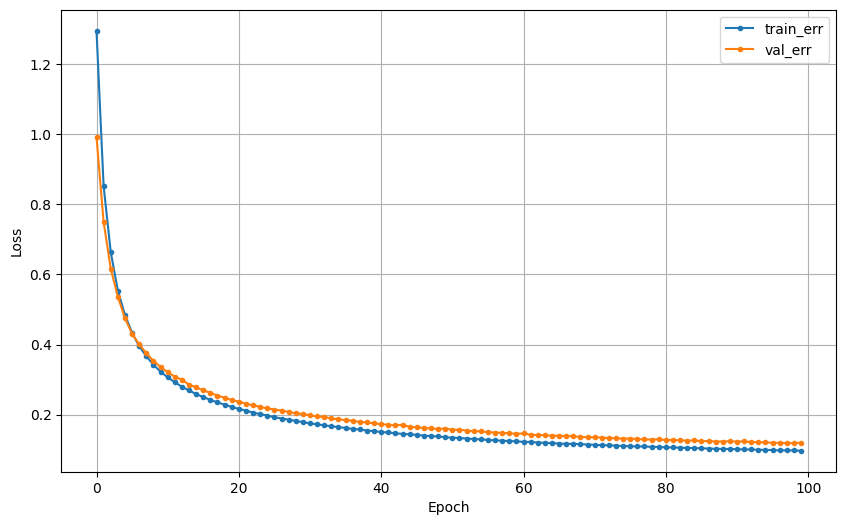

In [25]:
dl_history_plot(base_model.history.history)

In [26]:
pred = base_model.predict(x_val_scaled)
pred = np.argmax(pred,axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [27]:
print("Class to Integer Mapping:", class_mapping)
print(confusion_matrix (y_val,pred))
print(classification_report(y_val,pred))

Class to Integer Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
[[231   0   0   0   0   0]
 [  1 192   7   0   0   0]
 [  0  15 211   0   0   0]
 [  0   0   0 194   2   2]
 [  0   0   0   0 144   1]
 [  0   0   0   0   0 177]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       231
           1       0.93      0.96      0.94       200
           2       0.97      0.93      0.95       226
           3       1.00      0.98      0.99       198
           4       0.99      0.99      0.99       145
           5       0.98      1.00      0.99       177

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



In [ ]:
#top20 -> 0.89 top_50 -> 0.94  top_100 -> 0.95 top_200 -> 0.98 2번 클래스를 잘 구분하지 못하는것으로 보임

### (2) 모델2

In [ ]:
clear_session()
model2 = Sequential([Input(shape = (nfeatures,)),
                         Dense(18,activation = 'relu'),
                         Dense(18,activation = 'relu'),
                         Dense(12,activation = 'relu'),
                         Dense(10,activation = 'relu'),
                         Dense(10,activation = 'relu'),
                         Dense(6,activation = 'softmax')])
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 18)                  │           3,618 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 18)                  │             342 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │             228 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,494 (17.55 KB)

 Trainable params: 4,494 (17.55 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(optimizer = Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model2.fit(x_train_scaled,y_train,epochs=100,validation_split = 0.2)

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3177 - loss: 1.6102 - val_accuracy: 0.5526 - val_loss: 1.0338
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6072 - loss: 0.9262 - val_accuracy: 0.7194 - val_loss: 0.7753
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7613 - loss: 0.6287 - val_accuracy: 0.8629 - val_loss: 0.3524
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8938 - loss: 0.2973 - val_accuracy: 0.9001 - val_loss: 0.2549
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9116 - loss: 0.2294 - val_accuracy: 0.9022 - val_loss: 0.2744
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9295 - loss: 0.1886 - val_accuracy: 0.9139 - val_loss: 0.2001
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9344 - loss: 0.1664 - val_accuracy: 0.9373 - val_loss: 0.1644
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9424 - loss: 0.1524 - val_accu

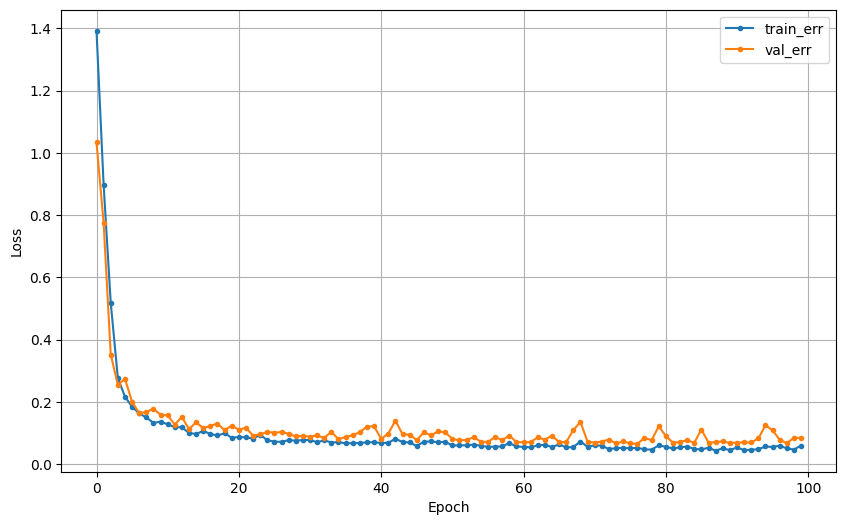

In [ ]:
dl_history_plot(model2.history.history)

In [ ]:
pred2 = model2.predict(x_val_scaled)
pred2 = np.argmax(pred2,axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
print("Class to Integer Mapping:", class_mapping)
print(confusion_matrix (y_val,pred2))
print(classification_report(y_val,pred2))

Class to Integer Mapping: {'LAYING': 0, 'SITTING': 1, 'STANDING': 2, 'WALKING': 3, 'WALKING_DOWNSTAIRS': 4, 'WALKING_UPSTAIRS': 5}
[[231   0   0   0   0   0]
 [  0 197   3   0   0   0]
 [  0  13 213   0   0   0]
 [  0   0   0 196   1   1]
 [  0   0   0   0 145   0]
 [  0   0   0   0   1 176]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       231
           1       0.94      0.98      0.96       200
           2       0.99      0.94      0.96       226
           3       1.00      0.99      0.99       198
           4       0.99      1.00      0.99       145
           5       0.99      0.99      0.99       177

    accuracy                           0.98      1177
   macro avg       0.98      0.99      0.98      1177
weighted avg       0.98      0.98      0.98      1177



In [ ]:
#top_20 ->50 0.9-> 0.95

### (3) 모델3

In [ ]:
clear_session()
model3 = Sequential([Input(shape = (nfeatures,)),
                         Dense(15,activation = 'relu'),
                         Dense(10,activation = 'relu'),
                         Dense(10,activation = 'relu'),
                         Dense(8,activation = 'relu'),
                         Dense(8,activation = 'relu'),
                         Dense(6,activation = 'softmax')])
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 15)                  │           1,515 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │              88 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,999 (7.81 KB)

 Trainable params: 1,999 (7.81 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3.compile(optimizer = Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model3.fit(x_train_scaled,y_train,epochs=100,validation_split = 0.2)

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2115 - loss: 1.7288 - val_accuracy: 0.3358 - val_loss: 1.2737
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4271 - loss: 1.1043 - val_accuracy: 0.5940 - val_loss: 0.7520
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6161 - loss: 0.7030 - val_accuracy: 0.6249 - val_loss: 0.6637
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6776 - loss: 0.6216 - val_accuracy: 0.6823 - val_loss: 0.6237
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7107 - loss: 0.5690 - val_accuracy: 0.6599 - val_loss: 0.6172
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7479 - loss: 0.5523 - val_accuracy: 0.6854 - val_loss: 0.5526
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7578 - loss: 0.5201 - val_accuracy: 0.7024 - val_loss: 0.5304
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7952 - loss: 0.4587 - val_accu

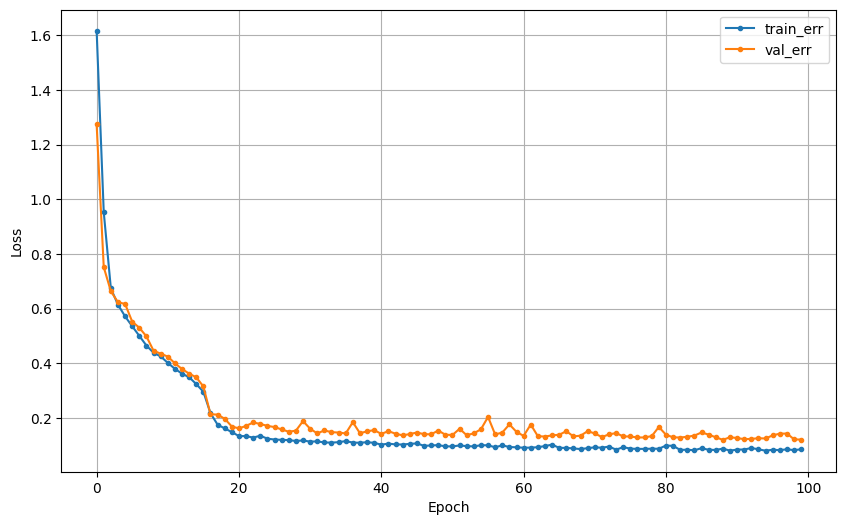

In [ ]:
dl_history_plot(model3.history.history)

In [ ]:
pred3 = model3.predict(x_val_scaled)
pred3 = np.argmax(pred3,axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
print(classification_report(y_val,pred3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       231
           1       0.93      0.83      0.88       200
           2       0.86      0.94      0.90       226
           3       0.98      0.97      0.98       198
           4       0.95      0.99      0.97       145
           5       0.98      0.97      0.97       177

    accuracy                           0.95      1177
   macro avg       0.95      0.95      0.95      1177
weighted avg       0.95      0.95      0.95      1177



### (4) 모델4

In [ ]:
clear_session()
model4 = Sequential([Input(shape = (nfeatures,)),
                         Dense(15,activation = 'relu'),
                         Dropout(0.1),
                         Dense(10,activation = 'relu'),

                         Dense(10,activation = 'relu'),
                         Dropout(0.1),
                         Dense(8,activation = 'relu'),

                         Dense(8,activation = 'relu'),
                         Dense(6,activation = 'softmax')])
model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 15)                  │           3,015 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │              88 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,499 (13.67 KB)

 Trainable params: 3,499 (13.67 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model4.compile(optimizer = Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model4.fit(x_train_scaled,y_train,epochs=100,validation_split = 0.2)

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4315 - loss: 1.3178 - val_accuracy: 0.6047 - val_loss: 1.0018
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5986 - loss: 0.9778 - val_accuracy: 0.6281 - val_loss: 0.8139
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6346 - loss: 0.7928 - val_accuracy: 0.7747 - val_loss: 0.6747
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6948 - loss: 0.6732 - val_accuracy: 0.8119 - val_loss: 0.5855
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7382 - loss: 0.6058 - val_accuracy: 0.8268 - val_loss: 0.5256
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7717 - loss: 0.5656 - val_accuracy: 0.8406 - val_loss: 0.4680
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8043 - loss: 0.5050 - val_accuracy: 0.8714 - val_loss: 0.4138
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8431 - loss: 0.4457 - val_accu

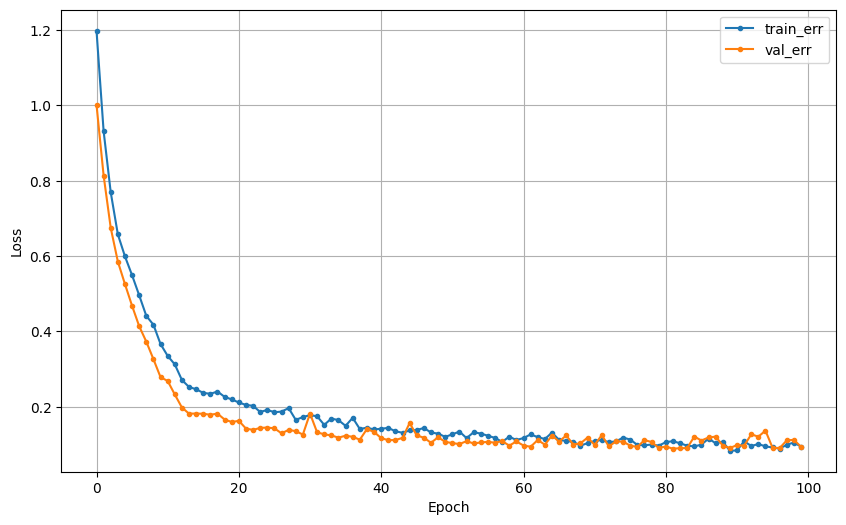

In [ ]:
dl_history_plot(model4.history.history)

In [ ]:
pred4 = model4.predict(x_val_scaled)
pred4 = np.argmax(pred4,axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
print("Class to Integer Mapping:", class_mapping)
print(confusion_matrix (y_val,pred4))
print(classification_report(y_val,pred4))

Class to Integer Mapping: {'LAYING': 0, 'SITTING': 1, 'STANDING': 2, 'WALKING': 3, 'WALKING_DOWNSTAIRS': 4, 'WALKING_UPSTAIRS': 5}
[[231   0   0   0   0   0]
 [  0 187  13   0   0   0]
 [  0   7 219   0   0   0]
 [  0   0   0 195   2   1]
 [  0   0   0   0 145   0]
 [  0   0   0   0   0 177]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       231
           1       0.96      0.94      0.95       200
           2       0.94      0.97      0.96       226
           3       1.00      0.98      0.99       198
           4       0.99      1.00      0.99       145
           5       0.99      1.00      1.00       177

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 15)                  │           3,015 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │              99 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │              63 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │              48 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,465 (13.54 KB)

 Trainable params: 3,465 (13.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2870 - loss: 1.6471 - val_accuracy: 0.3316 - val_loss: 1.3879
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3246 - loss: 1.3349 - val_accuracy: 0.4378 - val_loss: 1.0780
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4862 - loss: 0.9868 - val_accuracy: 0.5760 - val_loss: 0.7934
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5477 - loss: 0.8019 - val_accuracy: 0.6121 - val_loss: 0.7183
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6403 - loss: 0.6953 - val_accuracy: 0.7024 - val_loss: 0.6077
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6960 - loss: 0.5919 - val_accuracy: 0.7120 - val_loss: 0.5780
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7110 - loss: 0.5759 - val_accuracy: 0.7566 - val_loss: 0.5294
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7335 - loss: 0.5475 - val_accu

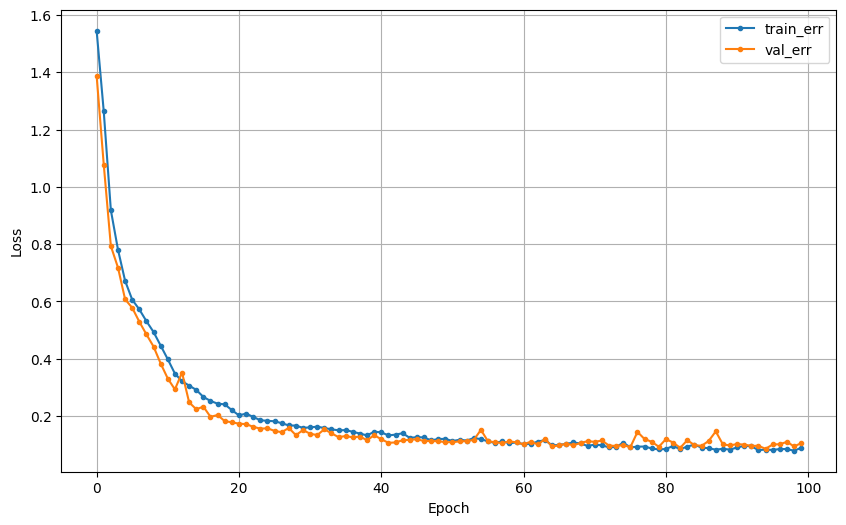

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Class to Integer Mapping: {'LAYING': 0, 'SITTING': 1, 'STANDING': 2, 'WALKING': 3, 'WALKING_DOWNSTAIRS': 4, 'WALKING_UPSTAIRS': 5}
[[231   0   0   0   0   0]
 [  0 192   8   0   0   0]
 [  0   4 222   0   0   0]
 [  0   0   0 195   1   2]
 [  0   0   0   0 142   3]
 [  0   0   0   0   0 177]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       231
           1       0.98      0.96      0.97       200
           2       0.97      0.98      0.97       226
           3       1.00      0.98      0.99       198
           4       0.99      0.98      0.99       145
           5       0.97      1.00      0.99       177

    accuracy                           0.98      1177
   macro avg       0.99      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



In [ ]:
clear_session()
model5 = Sequential([Input(shape = (nfeatures,)),
                         Dense(15,activation = 'relu'),
                         Dropout(0.1),
                         Dense(10,activation = 'relu'),
                         Dense(9,activation = 'relu'),
                         Dense(8,activation = 'relu'),
                         Dense(7,activation = 'relu'),
                         Dense(6,activation = 'softmax')])
model5.summary()
model5.compile(optimizer = Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model5.fit(x_train_scaled,y_train,epochs=100,validation_split = 0.2)
dl_history_plot(model5.history.history)
pred5 = model5.predict(x_val_scaled)
pred5 = np.argmax(pred5,axis=1)
print("Class to Integer Mapping:", class_mapping)
print(confusion_matrix (y_val,pred5))
print(classification_report(y_val,pred5))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 152)                 │          30,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 152)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 80)                  │          12,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 60)                  │           4,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 40)                  │           2,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,188 (199.95 KB)

 Trainable params: 51,188 (199.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3605 - loss: 1.4458 - val_accuracy: 0.7067 - val_loss: 0.6125
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7342 - loss: 0.5669 - val_accuracy: 0.8587 - val_loss: 0.3335
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8788 - loss: 0.3017 - val_accuracy: 0.8789 - val_loss: 0.2620
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8883 - loss: 0.2495 - val_accuracy: 0.9235 - val_loss: 0.1928
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9150 - loss: 0.2011 - val_accuracy: 0.9224 - val_loss: 0.1822
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9310 - loss: 0.1805 - val_accuracy: 0.9075 - val_loss: 0.1936
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9386 - loss: 0.1659 - val_accuracy: 0.9267 - val_loss: 0.1818
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9419 - loss: 0.1499 - val_accu

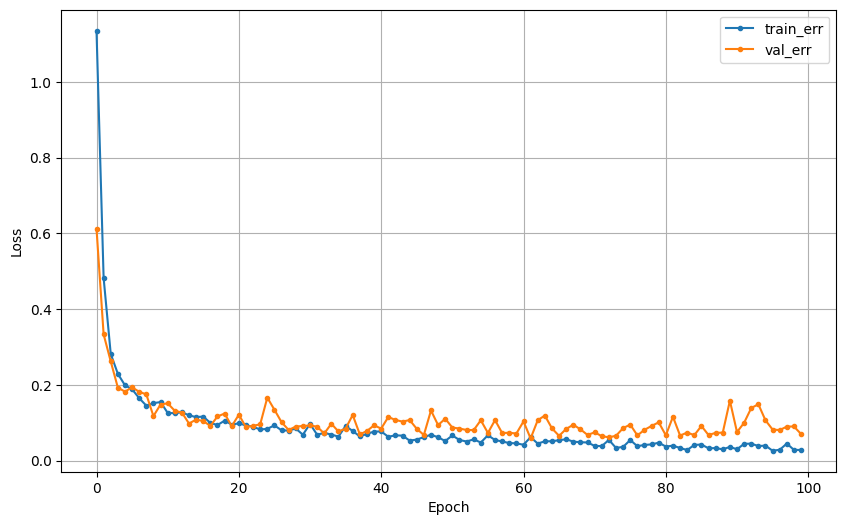

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Class to Integer Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
[[231   0   0   0   0   0]
 [  0 193   7   0   0   0]
 [  0   3 223   0   0   0]
 [  0   0   0 197   0   1]
 [  0   0   0   0 145   0]
 [  0   0   0   0   0 177]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       231
           1       0.98      0.96      0.97       200
           2       0.97      0.99      0.98       226
           3       1.00      0.99      1.00       198
           4       1.00      1.00      1.00       145
           5       0.99      1.00      1.00       177

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177



In [32]:
clear_session()
model6 = Sequential([Input(shape = (nfeatures,)),
                         Dense(152,activation = 'relu'),
                         Dropout(0.2),
                         Dense(80,activation = 'relu'),
                         Dropout(0.2),
                         Dense(60,activation = 'relu'),
                         Dense(40,activation = 'relu'),
                         Dense(20,activation = 'relu'),
                         Dense(10,activation = 'relu'),
                         Dense(6,activation = 'softmax')])
model6.summary()
model6.compile(optimizer = Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model6.fit(x_train_scaled,y_train,epochs=100,validation_split = 0.2)
dl_history_plot(model6.history.history)
pred6 = model6.predict(x_val_scaled)
pred6 = np.argmax(pred6,axis=1)
print("Class to Integer Mapping:", class_mapping)
print(confusion_matrix (y_val,pred6))
print(classification_report(y_val,pred6))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 152)                 │          30,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 152)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 120)                 │          18,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          12,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 80)                  │           8,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 60)                  │           4,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 40)                  │           2,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,488 (302.69 KB)

 Trainable params: 77,488 (302.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3923 - loss: 1.4675 - val_accuracy: 0.7588 - val_loss: 0.4954
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7946 - loss: 0.5050 - val_accuracy: 0.8757 - val_loss: 0.2906
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8844 - loss: 0.2883 - val_accuracy: 0.9267 - val_loss: 0.2152
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8958 - loss: 0.2639 - val_accuracy: 0.9437 - val_loss: 0.1614
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9190 - loss: 0.2098 - val_accuracy: 0.9224 - val_loss: 0.2113
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9234 - loss: 0.1914 - val_accuracy: 0.9437 - val_loss: 0.1500
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9399 - loss: 0.1673 - val_accuracy: 0.9469 - val_loss: 0.1421
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9485 - loss: 0.1467 - val_accu

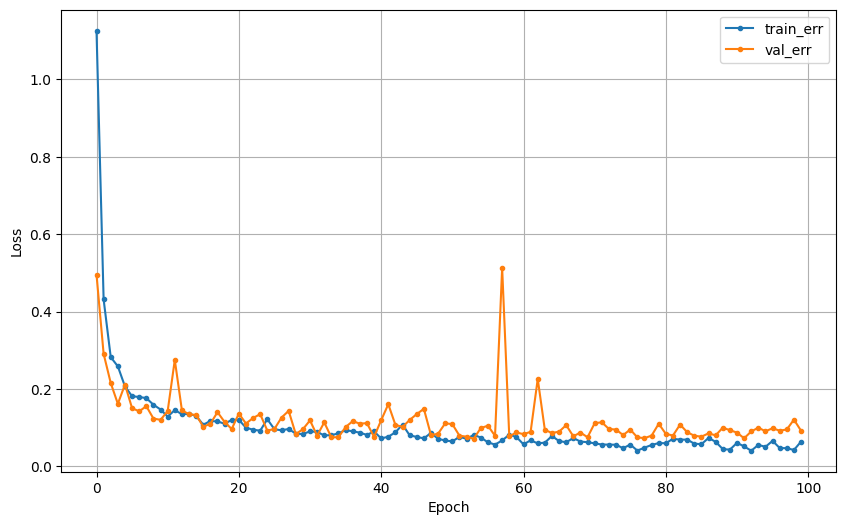

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Class to Integer Mapping: {'LAYING': 0, 'SITTING': 1, 'STANDING': 2, 'WALKING': 3, 'WALKING_DOWNSTAIRS': 4, 'WALKING_UPSTAIRS': 5}
[[231   0   0   0   0   0]
 [  0 195   5   0   0   0]
 [  0   6 220   0   0   0]
 [  0   0   0 195   0   3]
 [  0   0   0   0 142   3]
 [  0   0   0   0   0 177]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       231
           1       0.97      0.97      0.97       200
           2       0.98      0.97      0.98       226
           3       1.00      0.98      0.99       198
           4       1.00      0.98      0.99       145
           5       0.97      1.00      0.98       177

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177



In [ ]:
clear_session()
model7 = Sequential([Input(shape = (nfeatures,)),
                         Dense(152,activation = 'relu'),
                         Dropout(0.2),
                         Dense(120,activation = 'relu'),
                         Dropout(0.2),
                         Dense(100,activation = 'relu'),
                         Dense(80,activation = 'relu'),
                         Dropout(0.2),
                         Dense(60,activation = 'relu'),
                         Dense(40,activation = 'relu'),
                         Dense(20,activation = 'relu'),
                         Dense(10,activation = 'relu'),
                         Dense(6,activation = 'softmax')])
model7.summary()
model7.compile(optimizer = Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model7.fit(x_train_scaled,y_train,epochs=100,validation_split = 0.2)
dl_history_plot(model7.history.history)
pred7 = model7.predict(x_val_scaled)
pred7 = np.argmax(pred7,axis=1)
print("Class to Integer Mapping:", class_mapping)
print(confusion_matrix (y_val,pred7))
print(classification_report(y_val,pred7))

In [35]:
print(accuracy_score(y_val,pred6))

0.9906542056074766


## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [46]:
x_test =  test_data.drop(columns=['Activity'])
y_test = test_data['Activity']


In [47]:
x_test
print(test_data.shape)
print(x_test.shape)
print(y_test.shape)

(1471, 562)
(1471, 561)
(1471,)


In [50]:
data02 = test_data[top_200 + ['Activity']]
x_test =  data02.drop(columns=['Activity'])
y_test = data02['Activity']



In [51]:
x_test = scaler.transform(x_test)

In [60]:
y_test = encoder.transform(y_test)

In [61]:
pred_t6 = model6.predict(x_test)
pred_t6 = np.argmax(pred_t6,axis=1)
print(classification_report(y_test,pred_t6))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.98      0.96      0.97       254
           2       0.96      0.98      0.97       287
           3       1.00      0.99      0.99       228
           4       1.00      1.00      1.00       195
           5       0.99      1.00      0.99       215

    accuracy                           0.99      1471
   macro avg       0.99      0.99      0.99      1471
weighted avg       0.99      0.99      0.99      1471



In [63]:
print(accuracy_score(y_test,pred_t6))

0.9864038069340585
